In [1]:
import pandas as pd

# Data
df_partition = pd.read_csv("average_network_partition.csv", index_col=[0])
df_individuals_raw = pd.read_csv('../networks/data/global_before_1700.csv', index_col=[0])

df_partition['community'] = df_partition['community'].astype(int)
mapping = {0:'Human Domain', 1:'Natural Domain', 2:'Abstract Domain'}
df_partition['domain'] = df_partition['community'].apply(lambda x: mapping.get(x))

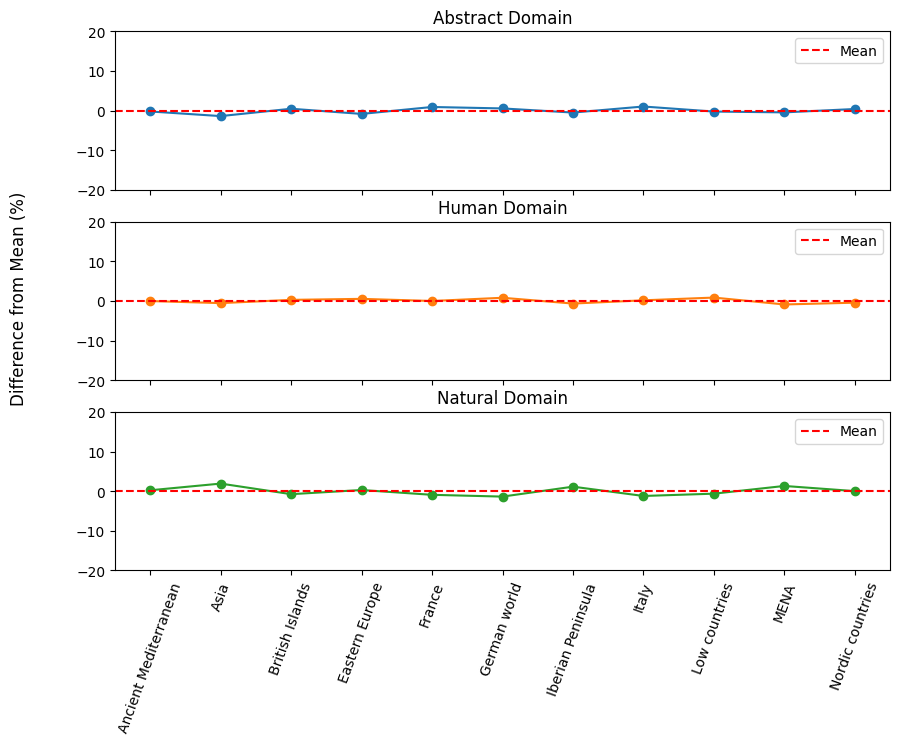

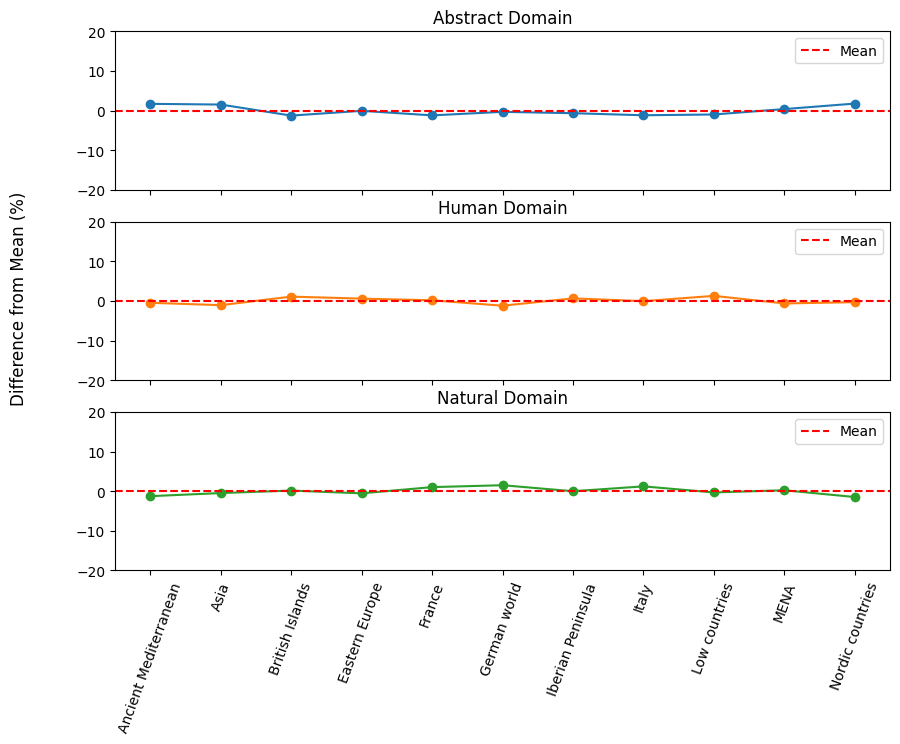

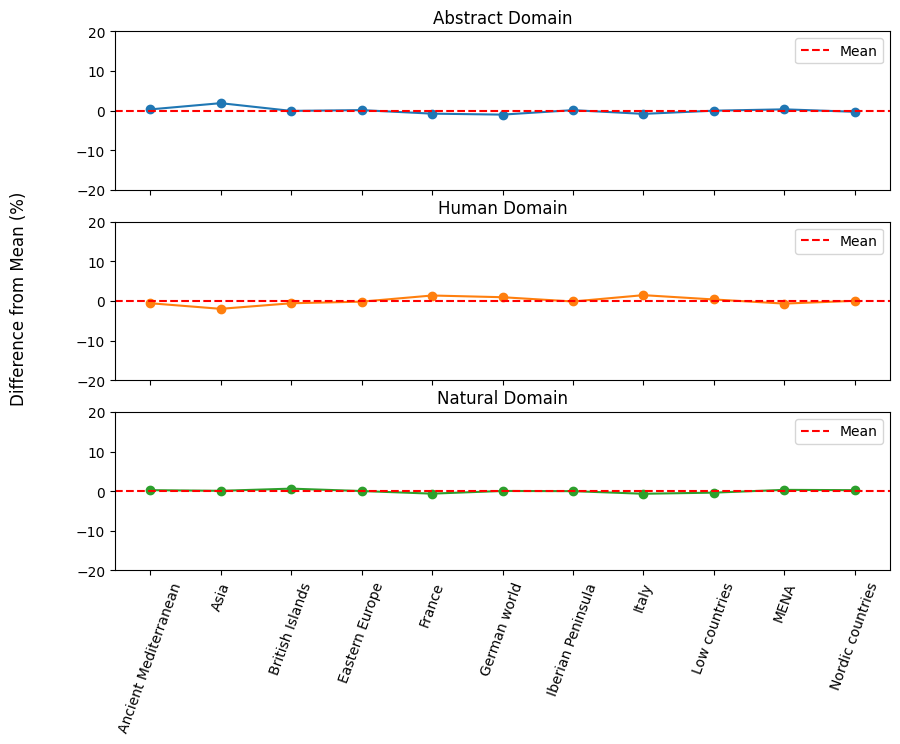

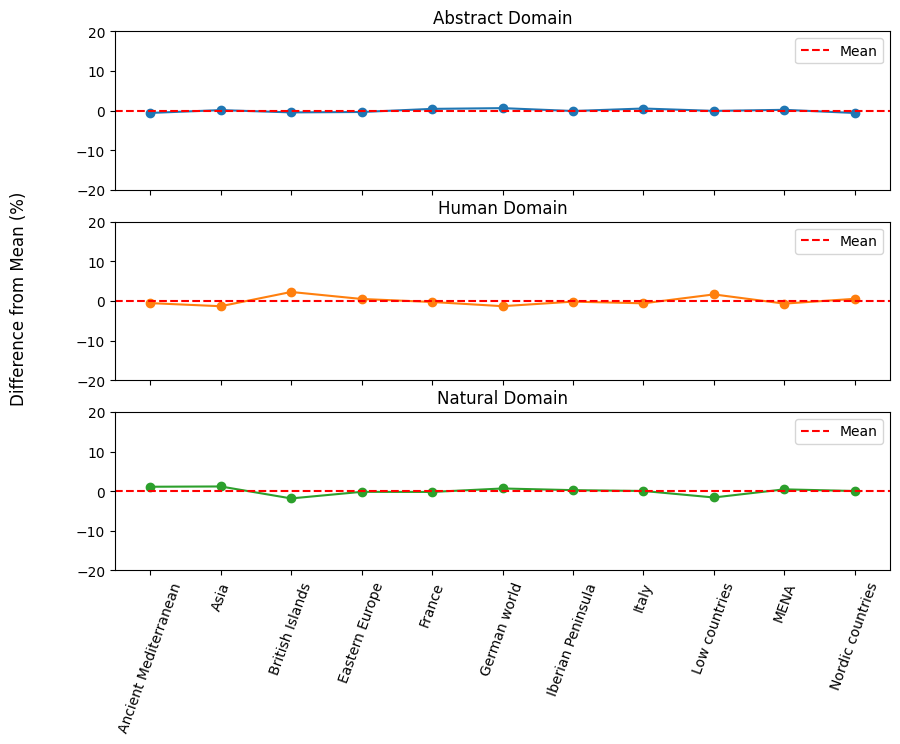

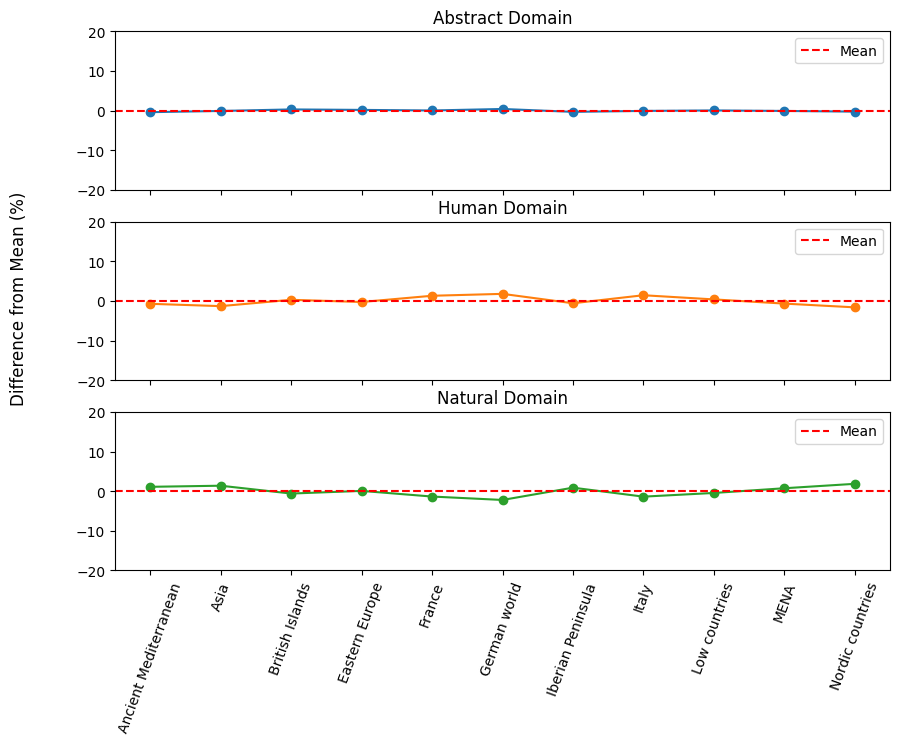

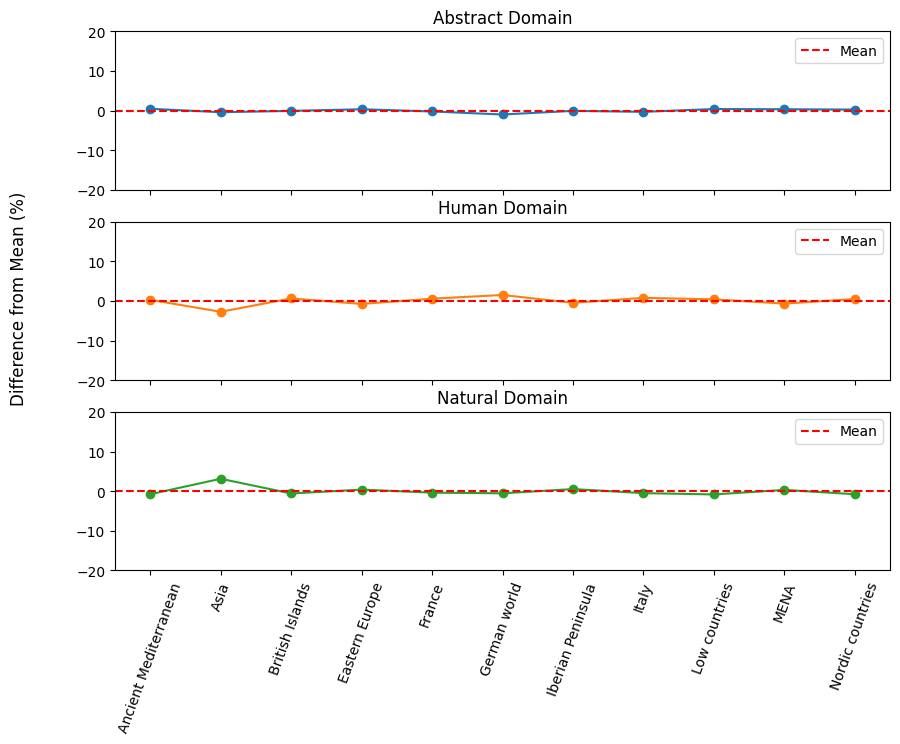

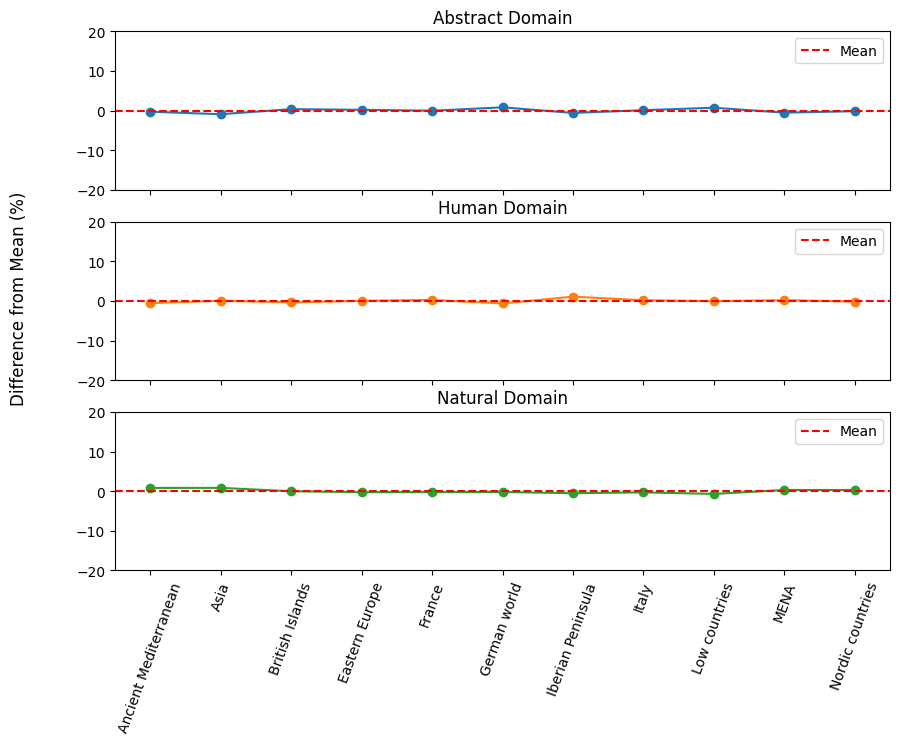

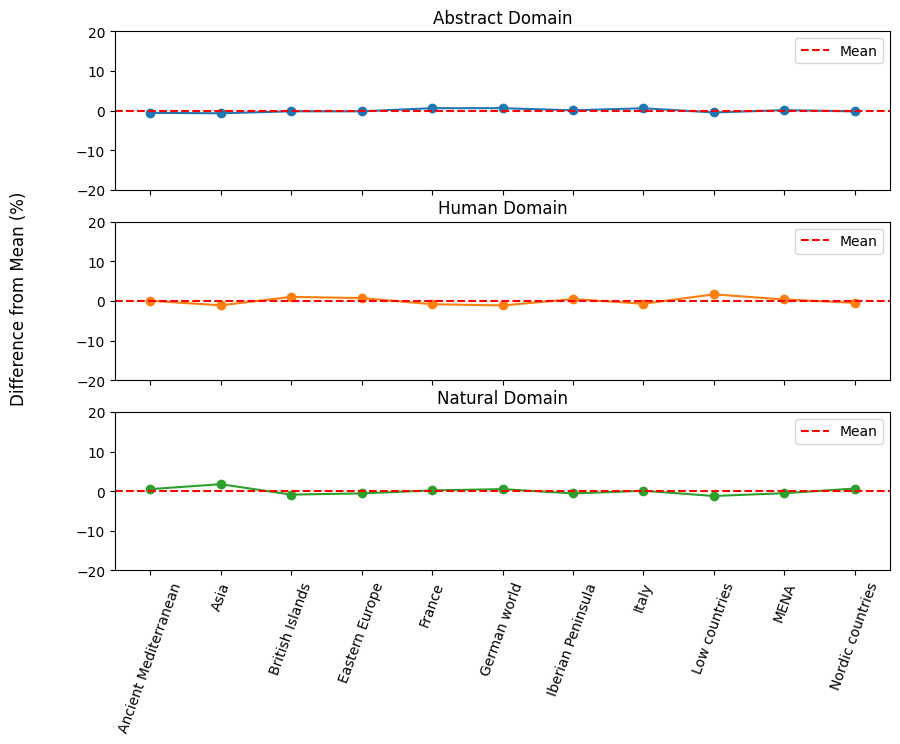

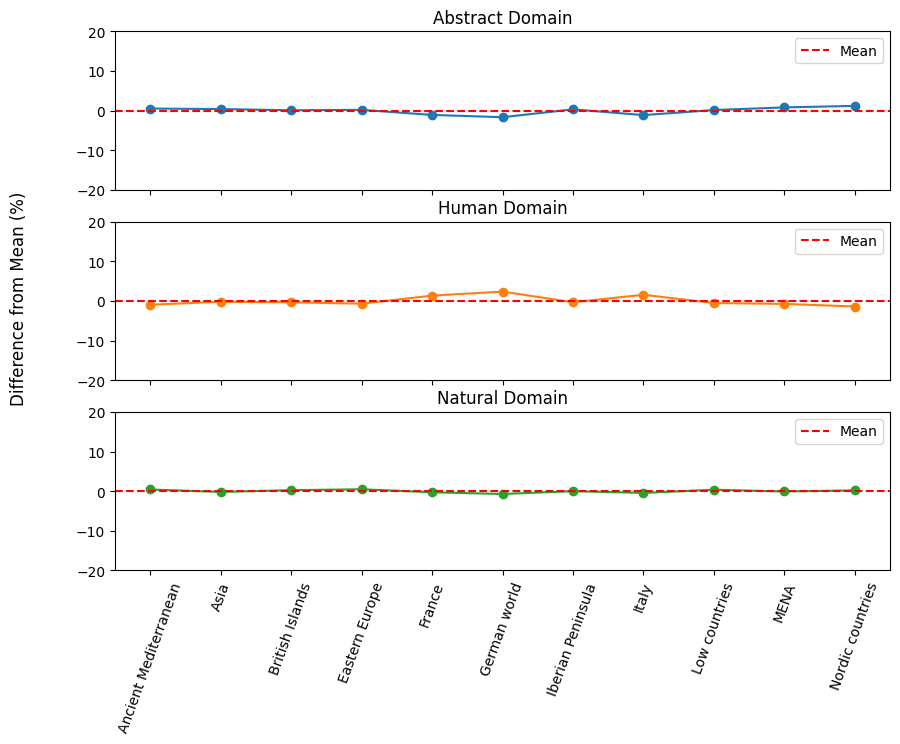

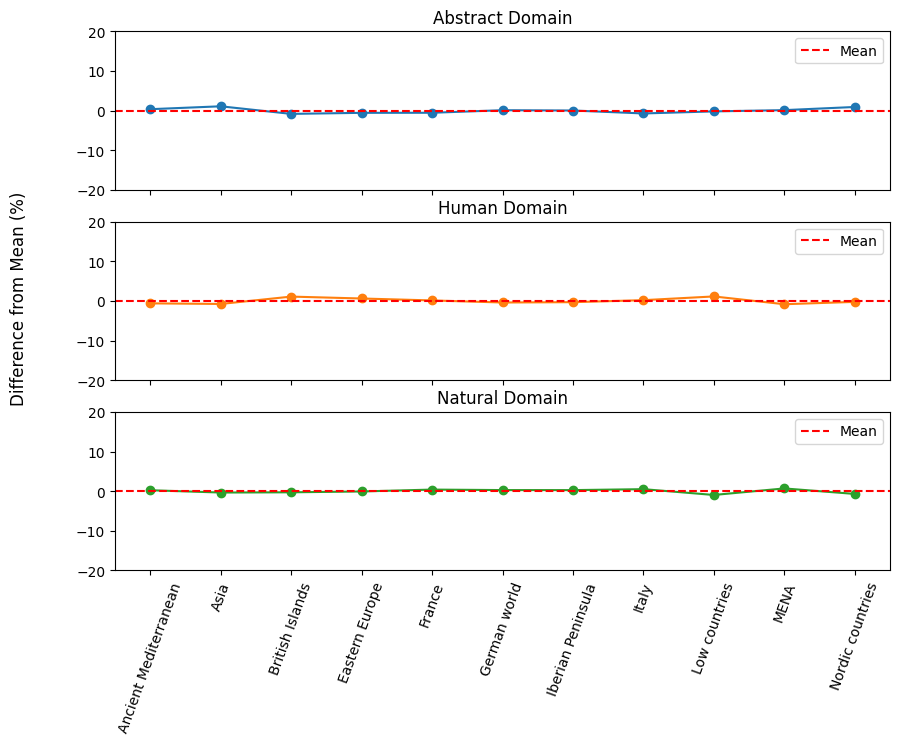

In [2]:
final_domains = []
list_df_stats = []

for x in range(10):

    df_individuals = df_individuals_raw[['wikidata_id', 'individual_name', 'region_name', 'meta_occupation']].copy()
    df_individuals['meta_occupation']  = df_individuals['meta_occupation'].apply(lambda x: x.split(' |'))
    df_individuals = df_individuals.explode('meta_occupation')
    df_individuals = df_individuals.rename(columns={'meta_occupation':'node'})
    df_individuals = pd.merge(df_individuals, df_partition, on = 'node')
    df_individuals = df_individuals.drop_duplicates(['wikidata_id', 'domain'], keep='first')

    df_individuals_all = df_individuals.drop('region_name', axis=1).drop_duplicates()

    region_counts = df_individuals.groupby('region_name')['wikidata_id'].count().reset_index()
    region_counts = dict(zip(region_counts['region_name'], region_counts['wikidata_id']))

    list_df = [] 
    for region in df_individuals.region_name.unique():
        df_sample = df_individuals_all.sample(region_counts[region], random_state=x) # Sample the individuals in the dataset
        df_sample['region_name'] = region
        list_df.append(df_sample)

    df_individuals = pd.concat([x for x in list_df])

    # for domain in df_individuals['domain'].unique():
    #     #print(domain)
    #     df_domain = df_individuals[df_individuals['domain']==domain]
    #     df_domain = df_domain[['wikidata_id', 'node']].drop_duplicates()
    #     #print(df_domain['node'].value_counts().head(3))

    # Remove those for original graph with original datasets
    bigger_regions = {'Central Europe':'Eastern Europe', 
                    'Slav world':'Eastern Europe',
                    'Balkans':'Eastern Europe',
                    'Korea':'Asia',
                    'Chinese world':'Asia', 
                    'Japan':'Asia', 
                    'Indian world':'Asia',
                    'South East Asia':'Asia', 
                    'Greek World':'Ancient Mediterranean', 
                    'Latin World':'Ancient Mediterranean',
                    'Arabic world':'MENA',
                    'Persian world':'MENA',
                    'Ottoman Turkey':'MENA',
                    'Spain':'Iberian Peninsula',
                    'Portugal':'Iberian Peninsula'}

    df_individuals['region_name'] = df_individuals['region_name'].apply(lambda x: bigger_regions.get(x, x))
    set(df_individuals['region_name'])

    # Group the data by region and domain and calculate the percentages
    df_country = df_individuals.groupby(['region_name', 'domain'])['wikidata_id'].count().rename('count_domains').reset_index()
    df_country = df_country.groupby(['region_name', 'domain']).agg({'count_domains': 'sum'})
    df_country = df_country.reset_index()

    # Create a DataFrame with all possible combinations of region_name and domain
    all_regions = df_country['region_name'].unique()
    all_domains = df_country['domain'].unique()
    all_combinations = [(r, d) for r in all_regions for d in all_domains]
    df_all_combinations = pd.DataFrame(all_combinations, columns=['region_name', 'domain'])

    merged_data = pd.merge(df_all_combinations, df_country, on=['region_name', 'domain'], how='left')
    merged_data['count_domains'] = merged_data['count_domains'].fillna(0)

    df_country = merged_data.copy()
    df_country = df_country.set_index('region_name')


    df_country['percent'] = (df_country['count_domains'] / df_country.groupby('region_name')['count_domains'].transform('sum')) * 100
    #df_country['percent'] = round(df_country['percent'], 1)
    df_country = df_country.reset_index()

    # Calculate the mean percentage for each domain
    mean_percentages = df_country.groupby('domain')['percent'].mean()
    mean_percentages.reset_index()['percent'].sum()

    import matplotlib.pyplot as plt

    # Create a new column for the difference from the mean
    df_country['difference_from_mean'] = df_country.apply(lambda row: row['percent'] - mean_percentages[row['domain']], axis=1)


    # Create a single graph with three subplots stacked on top of each other
    fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Adjust the height (7) as needed

    # List of unique domains
    domains = df_country['domain'].unique()

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Choose nicer colors

    for i, domain in enumerate(domains):
        domain_data = df_country[df_country['domain'] == domain]
        
        axs[i].plot(domain_data['region_name'], domain_data['difference_from_mean'], marker='o', linestyle='-', color=colors[i])
        axs[i].axhline(y=0, color='r', linestyle='--', label='Mean')
        #axs[i].set_ylabel('Difference from Mean (%)')
        axs[i].set_title(f'{domain}')
        axs[i].set_ylabel('')
        axs[i].set_xlabel('')
        axs[i].legend(loc='upper right')
        
        # Set the y-axis limits to -100 to 100
        axs[i].set_ylim(-20, 20)
        
        axs[i].legend()
        axs[i].grid(False)

    # Add a unique ylabel
    fig.supylabel('Difference from Mean (%)')

    #plt.tight_layout()
    plt.xticks(rotation=70)
    #plt.show()


    df_stats = df_country[['region_name', 'domain', 'difference_from_mean']].copy()
    list_df_stats.append(df_stats)
    domain_variance = df_stats.groupby('domain')['difference_from_mean'].std().to_dict()
    final_domains.append(domain_variance)


df_final = pd.concat([x for x in list_df_stats])
df_final =df_final.groupby(['region_name', 'domain'])['difference_from_mean'].mean().reset_index()
df_final.to_csv('domain_variations/random_spaces.csv')
    

## For time

In [3]:
import numpy as np
df_individuals_raw['century'] = df_individuals_raw['birthyear'].apply(lambda x : np.round(np.array(x) / 200) * 200)

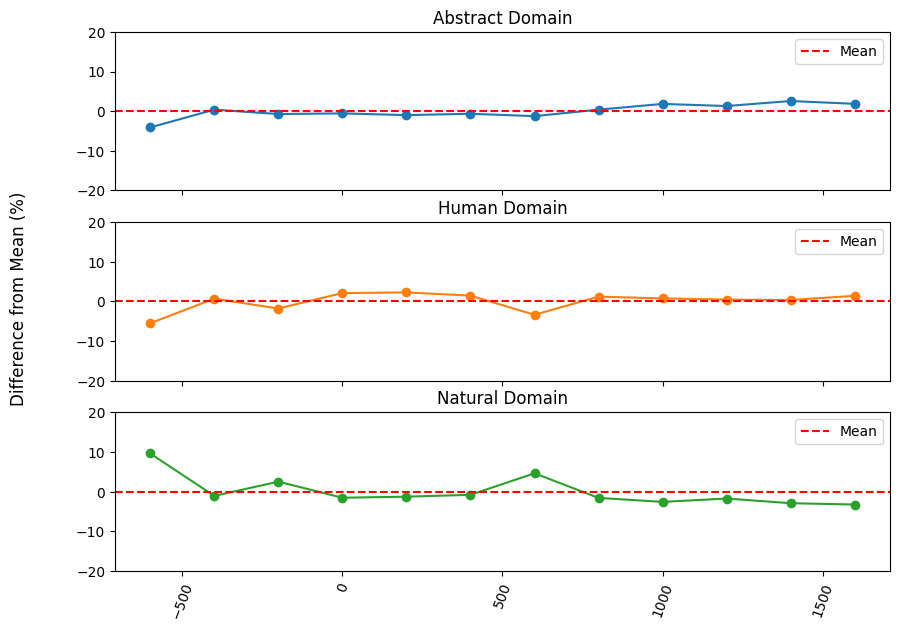

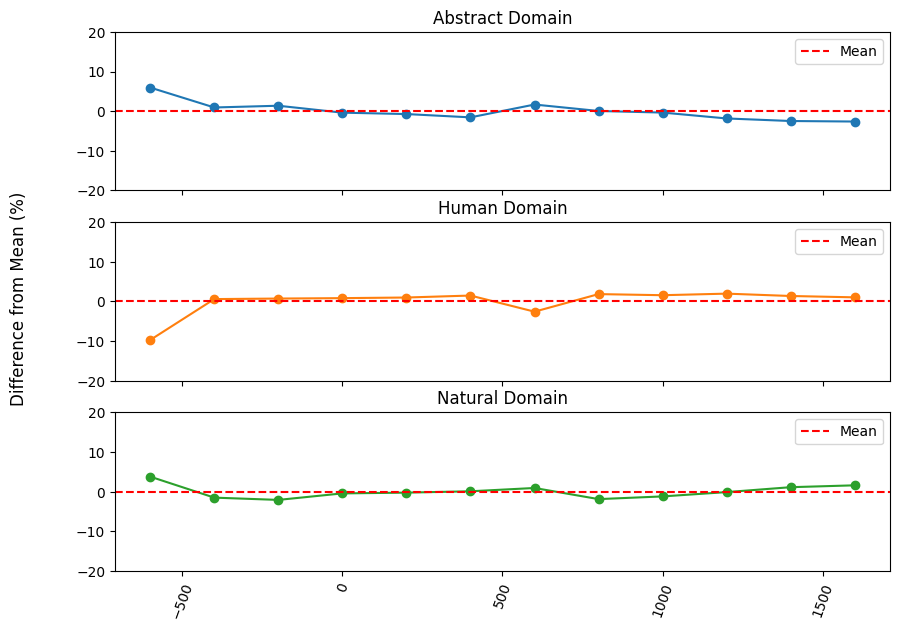

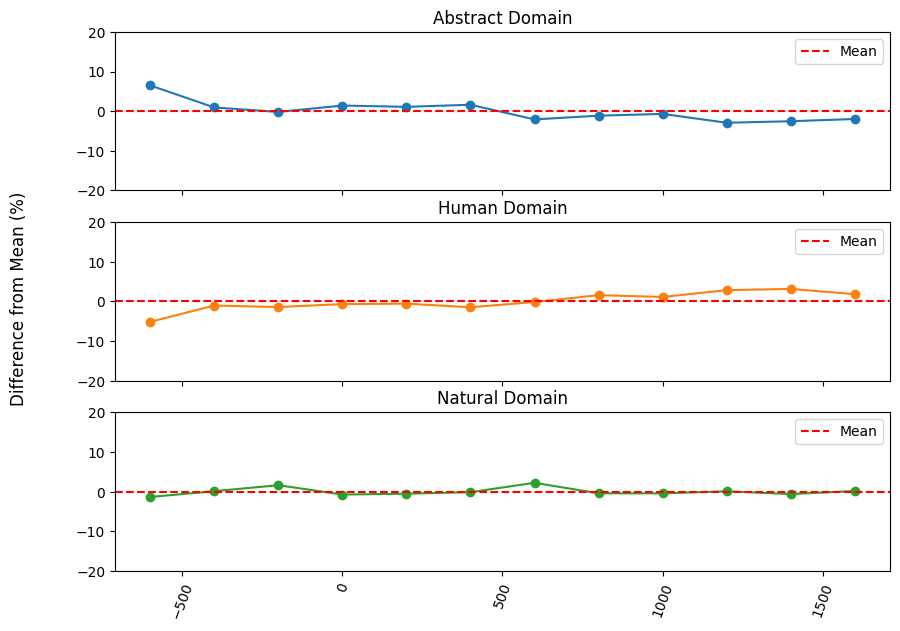

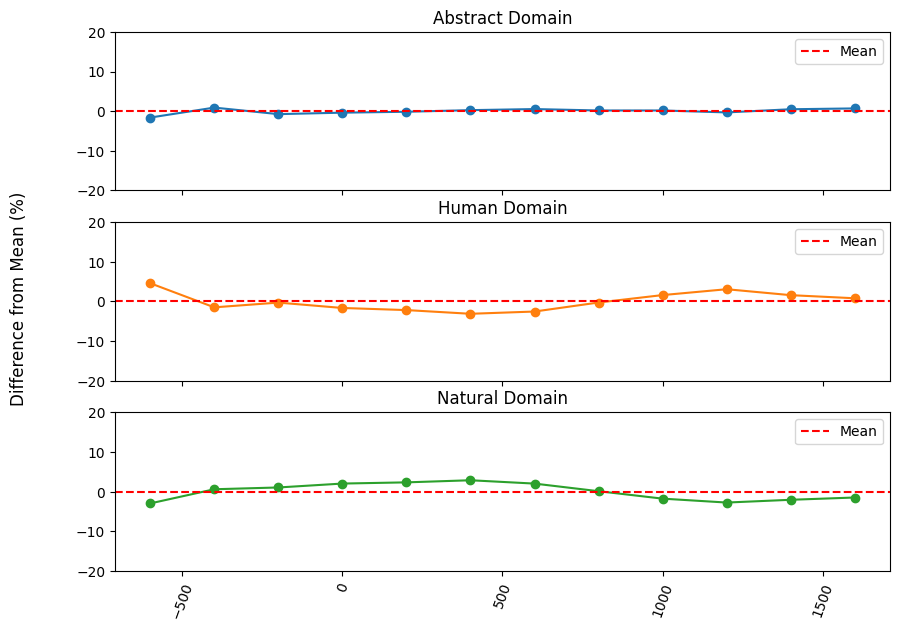

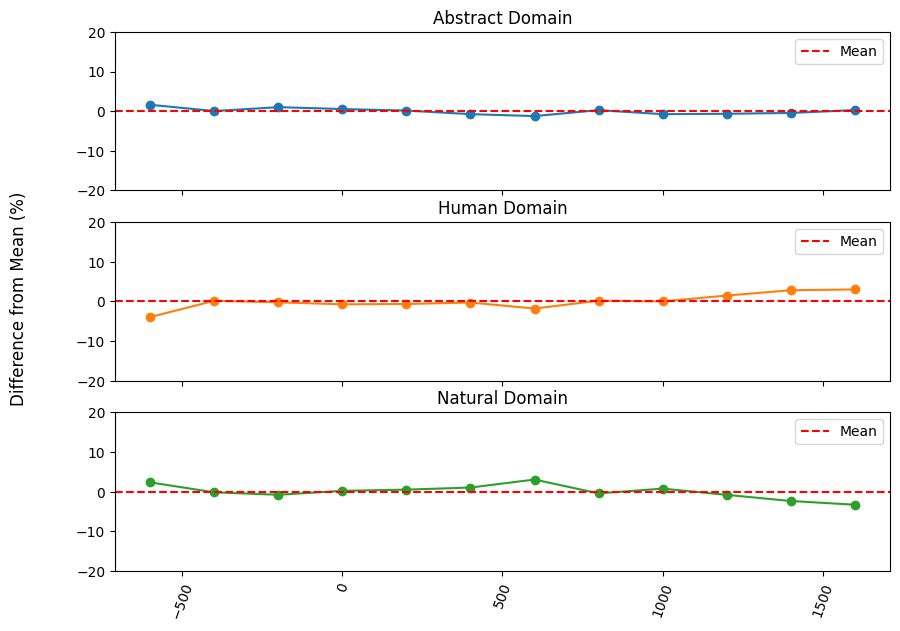

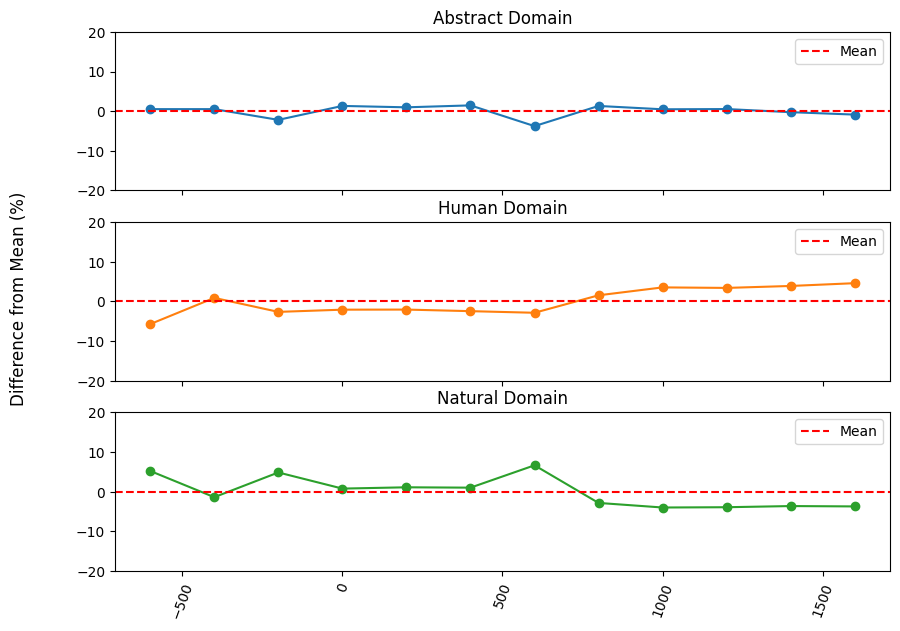

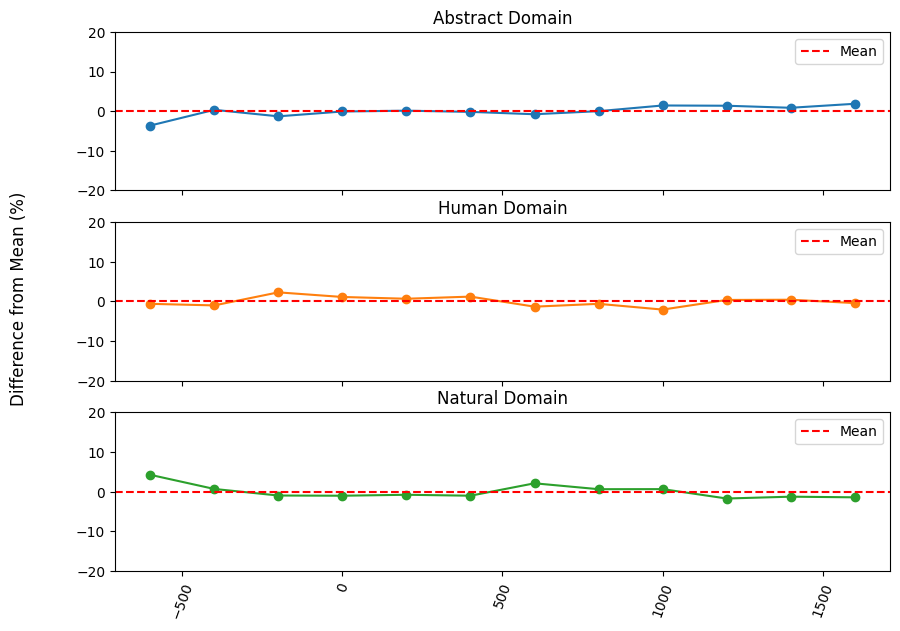

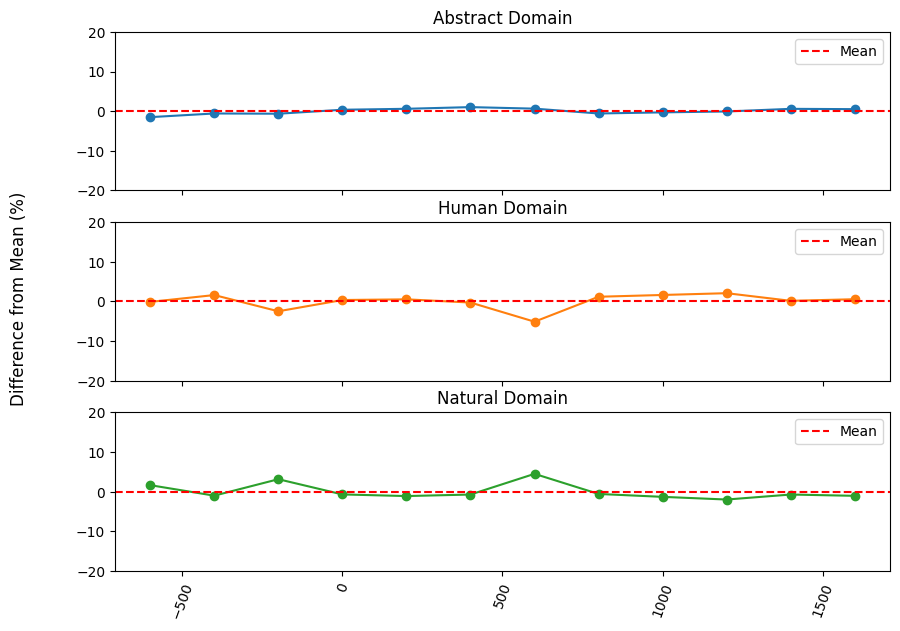

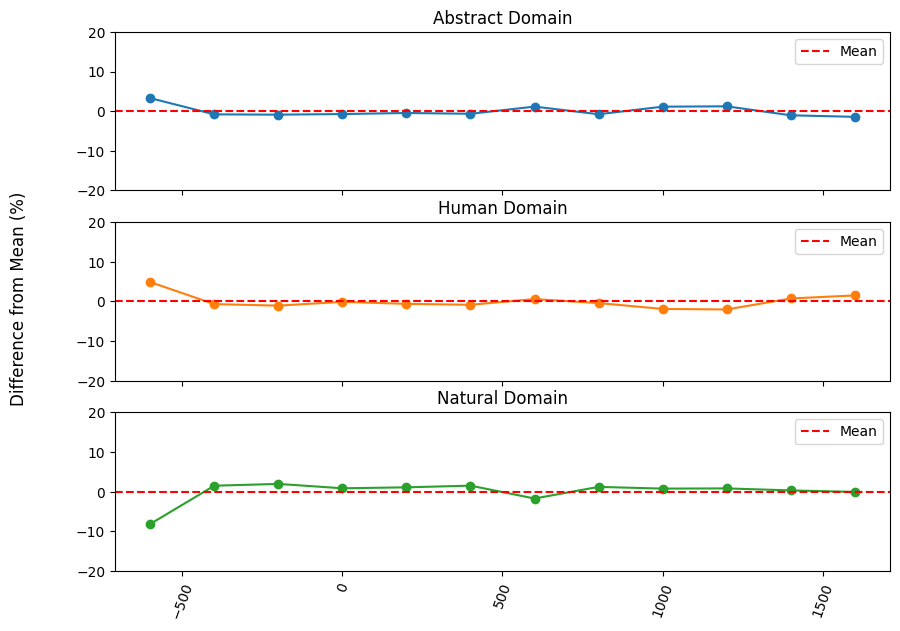

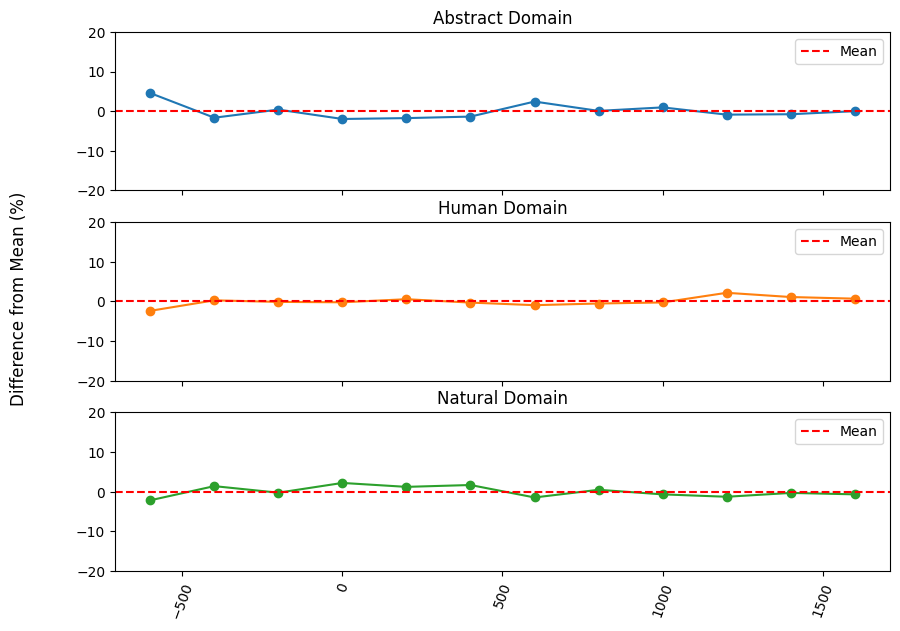

In [4]:
final_domains = []
list_df_stats = []

for x in range(10):

    df_individuals = df_individuals_raw[['wikidata_id', 'individual_name', 'century', 'meta_occupation']].copy()
    df_individuals['meta_occupation']  = df_individuals['meta_occupation'].apply(lambda x: x.split(' |'))
    df_individuals = df_individuals.explode('meta_occupation')
    df_individuals = df_individuals.rename(columns={'meta_occupation':'node'})
    df_individuals = pd.merge(df_individuals, df_partition, on = 'node')
    df_individuals = df_individuals.drop_duplicates(['wikidata_id', 'domain'], keep='first')
    df_individuals_all = df_individuals.drop('century', axis=1).drop_duplicates()

    century_counts = df_individuals.groupby('century')['wikidata_id'].count().reset_index()
    century_counts = dict(zip(century_counts['century'], century_counts['wikidata_id']))

    list_df = [] 
    for century in df_individuals.century.unique():
        df_sample = df_individuals_all.sample(century_counts[century], random_state=x) # Sample the individuals in the dataset
        df_sample['century'] = century
        list_df.append(df_sample)

    df_individuals = pd.concat([x for x in list_df])


        # Group the data by region and domain and calculate the percentages
    df_country = df_individuals.groupby(['century', 'domain'])['wikidata_id'].count().rename('count_domains').reset_index()
    df_country = df_country.groupby(['century', 'domain']).agg({'count_domains': 'sum'})
    df_country = df_country.reset_index()

    # Create a DataFrame with all possible combinations of region_name and domain
    all_centuries = df_country['century'].unique()
    all_domains = df_country['domain'].unique()
    all_combinations = [(r, d) for r in all_centuries for d in all_domains]
    df_all_combinations = pd.DataFrame(all_combinations, columns=['century', 'domain'])

    import numpy as np
    df_individuals = df_individuals_raw[['wikidata_id', 'individual_name', 'birthyear', 'meta_occupation']].copy()
    df_individuals['century'] = df_individuals['birthyear'].apply(lambda x : np.round(np.array(x) / 200) * 200
    )

    df_individuals['meta_occupation']  = df_individuals['meta_occupation'].apply(lambda x: x.split(' |'))
    df_individuals = df_individuals.explode('meta_occupation')
    df_individuals = df_individuals.rename(columns={'meta_occupation':'node'})
    df_individuals = pd.merge(df_individuals, df_partition, on = 'node')
    df_individuals = df_individuals.drop_duplicates(['wikidata_id', 'domain'], keep='first')


    # Group the data by region and domain and calculate the percentages
    df_time = df_individuals.groupby(['century', 'domain'])['wikidata_id'].count().rename('count_domains').reset_index()
    df_time = df_time.groupby(['century', 'domain']).agg({'count_domains': 'sum'})
    df_time = df_time.reset_index()
    df_time = df_time[df_time['century']>=-600]


    # Create a DataFrame with all possible combinations of region_name and domain
    all_times = df_time['century'].unique()
    all_domains = df_time['domain'].unique()
    all_combinations = [(r, d) for r in all_times for d in all_domains]
    df_all_combinations = pd.DataFrame(all_combinations, columns=['century', 'domain'])

    merged_data = pd.merge(df_all_combinations, df_time, on=['century', 'domain'], how='left')
    merged_data['count_domains'] = merged_data['count_domains'].fillna(0)

    df_time = merged_data.copy()
    df_time = df_time.set_index('century')


    df_time['percent'] = (df_time['count_domains'] / df_time.groupby('century')['count_domains'].transform('sum')) * 100
    #df_country['percent'] = round(df_country['percent'], 1)
    df_time = df_time.reset_index()


    merged_data = pd.merge(df_all_combinations, df_country, on=['century', 'domain'], how='left')
    merged_data['count_domains'] = merged_data['count_domains'].fillna(0)

    df_country = merged_data.copy()
    df_country = df_country.set_index('century')

    df_country['percent'] = (df_country['count_domains'] / df_country.groupby('century')['count_domains'].transform('sum')) * 100
    #df_country['percent'] = round(df_country['percent'], 1)
    df_country = df_country.reset_index()

    # Calculate the mean percentage for each domain
    mean_percentages = df_country.groupby('domain')['percent'].mean()
    mean_percentages.reset_index()['percent'].sum()

    import matplotlib.pyplot as plt

    # Create a new column for the difference from the mean
    df_country['difference_from_mean'] = df_country.apply(lambda row: row['percent'] - mean_percentages[row['domain']], axis=1)

    # Create a single graph with three subplots stacked on top of each other
    fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Adjust the height (7) as needed

    # List of unique domains
    domains = df_country['domain'].unique()

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Choose nicer colors

    for i, domain in enumerate(domains):
        domain_data = df_country[df_country['domain'] == domain]
        
        axs[i].plot(domain_data['century'], domain_data['difference_from_mean'], marker='o', linestyle='-', color=colors[i])
        axs[i].axhline(y=0, color='r', linestyle='--', label='Mean')
        #axs[i].set_ylabel('Difference from Mean (%)')
        axs[i].set_title(f'{domain}')
        axs[i].set_ylabel('')
        axs[i].set_xlabel('')
        axs[i].legend(loc='upper right')
        
        # Set the y-axis limits to -100 to 100
        axs[i].set_ylim(-20, 20)
        
        axs[i].legend()
        axs[i].grid(False)

    # Add a unique ylabel
    fig.supylabel('Difference from Mean (%)')

    #plt.tight_layout()
    plt.xticks(rotation=70)
    #plt.show()

    df_stats = df_country[['century', 'domain', 'difference_from_mean']].copy()
    list_df_stats.append(df_stats)
    domain_variance = df_stats.groupby('domain')['difference_from_mean'].std().to_dict()
    final_domains.append(domain_variance)

In [6]:
df_final = pd.concat([x for x in list_df_stats])
df_final = df_final.groupby(['century', 'domain'])['difference_from_mean'].mean().reset_index()

,century,domain,difference_from_mean
0,-600.0,Abstract Domain,1.156543
1,-600.0,Human Domain,-2.373163
2,-600.0,Natural Domain,1.216620
3,-400.0,Abstract Domain,0.098342
4,-400.0,Human Domain,-0.005438
5,-400.0,Natural Domain,-0.092904
6,-200.0,Abstract Domain,-0.392329
7,-200.0,Human Domain,-0.707749
8,-200.0,Natural Domain,1.100079
9,-0.0,Abstract Domain,-0.047410


In [5]:


df_final_domains = pd.DataFrame(final_domains)

print(df_final_domains['Abstract Domain'].mean())
print(df_final_domains['Abstract Domain'].std())

print(df_final_domains['Human Domain'].mean())
print(df_final_domains['Human Domain'].std())

print(df_final_domains['Natural Domain'].mean())
print(df_final_domains['Natural Domain'].std())

df_final.to_csv('domain_variations/random_times.csv')

1.537263842513958
0.6565210565506092
2.1798158420788494
0.7464190214734877
2.211423280876444
0.9697131715311271
